## Classification on 8 celebrities

In this notebook we try to classify images of : "Miranda_Cosgrove" "Chris_Martin" "Emma_Stone" "Jamie_Foxx" "Steve_Jobs" "Zac_Efron" "Sandra_Oh" "Taryn_Manning". There are 350 images of each celebrity, we use 250 for traning and 50 for validation and test.

In [1]:
#!pip3 install sklearn ##for docker users

In [2]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline
import h5py

Reading in the data, it is already prepared in a train, validation and testset. The class labels are form 0 to 7. The pixelsize of every image is 48x48 and we have 3 channels (RGB) per image. All 3 sets are balanced.

In [3]:
# Downloading the data, if it does not exist, this will take some time... (>120MB)
import urllib
import os
if not os.path.isfile('8_faces_train_and_valid.hdf5'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/dx03vk6dmbtoywn/8_faces_train_and_valid.hdf5?dl=1",
    "8_faces_train_and_valid.hdf5")

In [4]:
h5f_X = h5py.File('8_faces_train_and_valid.hdf5', 'r')
print(list(h5f_X.keys()))
X_train = h5f_X['X_train_8_faces']
print(X_train.shape)
Y_train = h5f_X['Y_train_8_faces']
print(Y_train.shape)
X_valid = h5f_X['X_valid_8_faces']
print(X_valid.shape)
Y_valid = h5f_X['Y_valid_8_faces']
print(Y_valid.shape)

['X_train_8_faces', 'X_valid_8_faces', 'Y_train_8_faces', 'Y_valid_8_faces']
(2000, 48, 48, 3)
(2000,)
(400, 48, 48, 3)
(400,)


(array([250., 250., 250., 250., 250., 250., 250., 250.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <a list of 8 Patch objects>)

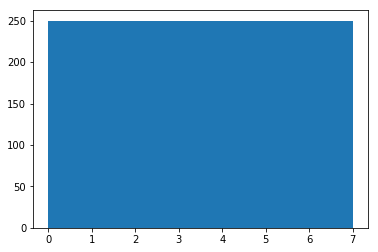

In [5]:
plt.hist(Y_train,bins=8)

(array([50., 50., 50., 50., 50., 50., 50., 50.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <a list of 8 Patch objects>)

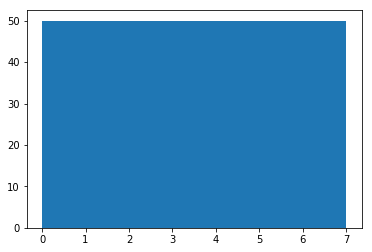

In [6]:
plt.hist(Y_valid,bins=8)

How hard is this task? Lets plot some random image of the trainset to get an impression of the images and of  the task. 

5


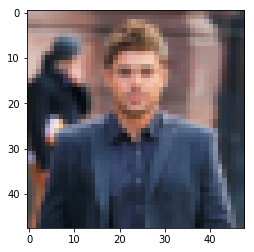

In [7]:
rmd=np.random.randint(0,len(X_train))
print(Y_train[rmd])
plt.imshow(np.asarray(X_train[rmd],dtype="uint8"))

#### Normalization of the training and validationset.

In [8]:
X_mean = np.mean( X_train, axis = 0)
X_std = np.std( X_train, axis = 0)

X_train = (X_train - X_mean ) / (X_std + 0.0001)
X_valid = (X_valid - X_mean ) / (X_std + 0.0001)

#### Flattern the images into a vector because we unly use fully connected layers in this model

In [9]:
X_train_flatten=np.zeros([len(X_train),48*48*3])
for i in range(0,len(X_train)):
    X_train_flatten[i]=np.reshape(X_train[i],newshape=((48*48*3),))
    
X_valid_flatten=np.zeros([len(X_valid),48*48*3])
for i in range(0,len(X_valid)):
    X_valid_flatten[i]=np.reshape(X_valid[i],newshape=((48*48*3),))
print(X_train_flatten.shape)
print(X_valid_flatten.shape)

(2000, 6912)
(400, 6912)


Define the convertToOneHot function and convert the labels into the onehot encoding.

In [10]:
def convertToOneHot(vector, num_classes=None):
    result = np.zeros((len(vector), num_classes), dtype='int32')
    result[np.arange(len(vector)), vector] = 1
    return result

In [11]:
Y_train=convertToOneHot(Y_train,num_classes=8)
Y_valid=convertToOneHot(Y_valid,num_classes=8)

In [12]:
print(Y_train[13])
print(Y_valid[13])

[0 0 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0]


### Define the network

In [13]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [14]:
batch_size = 128
nb_classes = 8
nb_epoch = 50

In [15]:
model = Sequential()
name = 'only_fc'

model.add(Dense(400,input_dim=(48*48*3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(500))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(200))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 400)               2765200   
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)               1600      
_________________________________________________________________
activation_1 (Activation)    (None, 400)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               200500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
_________________________________________________________________
activation_2 (Activation)    (None, 500)               0         
__________

### Running a forward pass of the untrained network

In [17]:
model.evaluate(X_train_flatten,Y_train)

2000/2000 [==============================] - 1s 366us/step


[2.279938192367554, 0.112]

In [18]:
tensorboard = keras.callbacks.TensorBoard(
        log_dir='tensorboard/8_faces/' + name + '/', 
        write_graph=True,
        histogram_freq=1)

In [19]:
#save model after every 10 epochs in "Checkpoints/8_facesl/model_1_fc/"-folder
os.makedirs("Checkpoints/8_faces/model_1_fc/",exist_ok=True)       
checkpointer = keras.callbacks.ModelCheckpoint( 
        filepath =  "Checkpoints/8_faces/model_1_fc/fc_model_"+"weights_epoch_{epoch:03d}-{val_loss:.2f}.hdf5",
        verbose = 1, 
        save_best_only = False,
        period = 10 )

### Training the network

In [20]:
history=model.fit(X_train_flatten, Y_train, 
                  batch_size=batch_size, 
                  epochs=nb_epoch,
                  verbose=1, 
                  validation_data=(X_valid_flatten, Y_valid),
                  callbacks=[tensorboard,checkpointer],)

Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 400 samples
Epoch 1/50
2000/2000 [==============================] - 2s 1ms/step - loss: 2.4301 - acc: 0.1955 - val_loss: 2.0984 - val_acc: 0.2950
Epoch 2/50
2000/2000 [==============================] - 1s 560us/step - loss: 2.1530 - acc: 0.2600 - val_loss: 1.8373 - val_acc: 0.3650
Epoch 3/50
2000/2000 [==============================] - 1s 562us/step - loss: 1.9770 - acc: 0.2965 - val_loss: 1.6986 - val_acc: 0.3850
Epoch 4/50
2000/2000 [==============================] - 1s 608us/step - loss: 1.9102 - acc: 0.3160 - val_loss: 1.6267 - val_acc: 0.4075
Epoch 5/50
2000/2000 [==============================] - 1s 581us/step - loss: 1.8017 - acc: 0.3520 - val_loss: 1.5456 - val_acc: 0.4375
Epoch 6/50
2000/2000 [==============================] - 1s 587us/step - loss: 1.7540 - acc: 0.3465 - val_loss: 1.5157 - val_acc: 0.4675
Epoch 7/50
2000/2000 [==============================] - 1s 598us/step - loss: 1.6850 - acc:

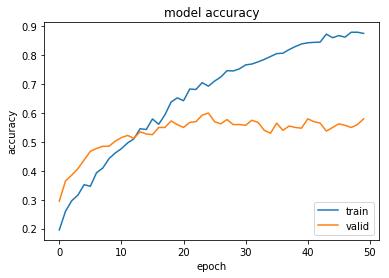

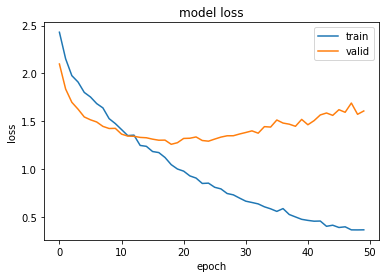

In [21]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

### Evaluation of the trained network

In [22]:
#load a saved model
from keras.models import load_model
model = load_model("Checkpoints/8_faces/model_1_fc/fc_model_weights_epoch_020-1.28.hdf5")

In [23]:
preds=model.predict(X_valid_flatten)

In [24]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(np.argmax(Y_valid,axis=1),np.argmax(preds,axis=1)))
print("Acc = " ,np.sum(np.argmax(Y_valid,axis=1)==np.argmax(preds,axis=1))/len(preds))

[[34  2  3  2  2  1  5  1]
 [ 2 13  1 10  5 16  0  3]
 [ 3  1 36  2  0  2  1  5]
 [ 2  4  2 37  1  2  2  0]
 [ 0  1  0  3 42  2  1  1]
 [ 3  4  7  3  3 28  2  0]
 [11  1  5  5  4  3 18  3]
 [ 3  5  7  5  5  7  2 16]]
Acc =  0.56


### You will get the test set later, optimize your network on the validation set